In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

In [3]:
SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [5]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '../data')
OUTPUT_DIR = os.path.join(BASE_DIR, '../output')

In [6]:
data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
dataset_train, dataset_valid = train_test_split(data, test_size=0.3, stratify=data['target'],random_state=SEED)

In [9]:
model_name = 'klue/bert-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initial

In [7]:
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        targets = data['target']
        self.inputs = []
        self.labels = []
        
        for text, label in zip(input_texts, targets):
            tokenized_input = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),  
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }
    
    def __len__(self):
        return len(self.labels)

In [10]:
data_train = BERTDataset(dataset_train, tokenizer)
data_valid = BERTDataset(dataset_valid, tokenizer)

In [19]:
n,m=len(data_train),len(data_train[0]['input_ids'])
torch_embed,torch_label=torch.zeros(n, m),torch.zeros(n, 1)
for i in range(len(data_train)):
    torch_embed[i],torch_label[i]=data_train[i]['input_ids'],data_train[i]['labels']

## Dimension Reduction

### PCA

In [23]:
from sklearn.decomposition import PCA

n_components=2
pca = PCA(n_components=n_components)
printcipalComponents = pca.fit_transform(torch_embed)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['pc1', 'pc2'])
principalDf['target']=torch_label

In [24]:
principalDf.head()

,pc1,pc2,target
0,-4299.449215,2362.565715,2.0
1,11260.511367,4236.940511,0.0
2,12737.726557,-1985.220105,3.0
3,-3586.333862,950.034627,4.0
4,-7937.028726,2345.594019,6.0


### t-sne

In [31]:
from sklearn.manifold import TSNE

model = TSNE(n_components=n_components)
X_embedded = model.fit_transform(torch_embed)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Visualization

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt

palette = sns.color_palette("bright", 10)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=torch_label, legend='full', palette=palette)
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 3 keyword-only arguments) were given

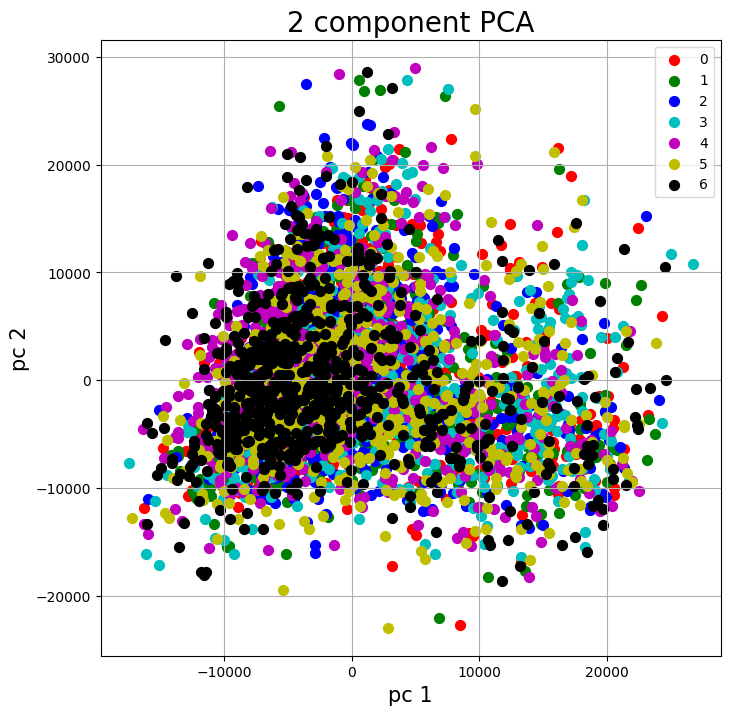

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('pc 1', fontsize = 15)
ax.set_ylabel('pc 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets=range(7)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'pc1']
               , principalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()